# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Проверка гипотезы о времени активности пользователей в приложении

- Автор:Дорошенко Евгений
- Дата:22.08.2025

## Цели и задачи проекта

Проверка гипотез в Python и результаты А/Б-теста и анализ результатов A/B-тестирования.

## Описание данных
Данные
https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов.
Структура файла:
user_id — идентификатор пользователя;
group — группа пользователя;
ab_test — название теста;
device — устройство, с которого происходила регистрация.
https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;
Структура файла:
user_id — идентификатор пользователя;
event_dt — дата и время события;
event_name — тип события;
details — дополнительные данные о событии.

## Содержимое проекта

Введение
- Цели и задачи проекта
- Описание данных и источников

Загрузка и подготовка данных
- Загрузка данных из CSV-файлов
- Проверка наличия дубликатов и их устранение
- Объединение и предварительный анализ данных

Анализ гипотезы о времени активности пользователей
- Формулировка гипотезы
- Выбор статистического теста (t-тест)
- Проверка условий применения теста
- Проведение теста и интерпретация результатов
- Обсуждение возможных причин полученных результатов

Анализ результатов A/B-теста
- Загрузка данных о тестировании
- Проверка корректности проведения теста
- Анализ конверсии и статистическая проверка гипотезы
- Вывод результатов A/B-тестирования



## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Загрузим данные
import pandas as pd
from scipy import stats
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
df = pd.read_csv('/datasets/yandex_knigi_data.csv')

In [3]:
# Просмотр первых строк
display(df.head())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Общая информация о данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 8784 entries, 0 to 8783
,Data columns (total 4 columns):
, #   Column      Non-Null Count  Dtype  
,---  ------      --------------  -----  
, 0   Unnamed: 0  8784 non-null   int64  
, 1   city        8784 non-null   object 
, 2   puid        8784 non-null   int64  
, 3   hours       8784 non-null   float64
,dtypes: float64(1), int64(2), object(1)
,memory usage: 274.6+ KB
,None


In [5]:
# 2. Проверка на дубликаты
duplicates = df['puid'].duplicated().sum()
print(f'Количество дубликатов puid: {duplicates}')

Количество дубликатов puid: 244


 В некоторых случаях дубликаты могут быть допустимы.  Например, один и тот же пользователь мог совершить несколько действий, которые случайно зарегистрировались как разные записи с одинаковым puid.Поэтому дубли удалять не будем а проведем агрегацию

In [6]:
# Группируем по 'puid', вычисляем среднее значение 'hours' и берем первое значение 'city'
df = df.groupby('puid').agg({'hours': 'mean', 'city': 'first'}).reset_index()



In [7]:
# 3. Разделение данных по городам
moscow = df[df['city'] == 'Москва']['hours']
spb = df[df['city'] == 'Санкт-Петербург']['hours']

In [8]:
# 4. Сравнение размеров групп и статистик
print(f'Медиана времени в Москве: {moscow.median()}')
print(f'Медиана времени в Санкт-Петербурге: {spb.median()}')
print(f'Минимальное время в Москве: {moscow.min()}')
print(f'Минимальное время в Санкт-Петербурге: {spb.min()}')
print(f'Максимальное время в Москве: {moscow.max()}')
print(f'Максимальное время в Санкт-Петербурге: {spb.max()}')
print(f'Q1 (25-й перцентиль) в Москве: {moscow.quantile(0.25)}')
print(f'Q1 (25-й перцентиль) в Санкт-Петербурге: {spb.quantile(0.25)}')
print(f'Q3 (75-й перцентиль) в Москве: {moscow.quantile(0.75)}')
print(f'Q3 (75-й перцентиль) в Санкт-Петербурге: {spb.quantile(0.75)}')


Медиана времени в Москве: 0.9790666666666668
,Медиана времени в Санкт-Петербурге: 0.8753550505050504
,Минимальное время в Москве: 2.19444444444e-05
,Минимальное время в Санкт-Петербурге: 2.52777777777e-05
,Максимальное время в Москве: 857.2093727777777
,Максимальное время в Санкт-Петербурге: 978.7647747474748
,Q1 (25-й перцентиль) в Москве: 0.06330151515151507
,Q1 (25-й перцентиль) в Санкт-Петербурге: 0.060173194444444425
,Q3 (75-й перцентиль) в Москве: 6.139026805555556
,Q3 (75-й перцентиль) в Санкт-Петербурге: 6.1384235416666675


Медианное время в Москве: 0.98 часа
Медианное время в Санкт-Петербурге: 0.88 часа

Разница в медианных значениях (0.10 часа) говорит о том, что пользователи из Москвы в среднем проводят больше времени в приложении, чем пользователи из Санкт-Петербурга.

Q1 и Q3 также близки друг к другу, что может свидетельствовать о схожести распределения времени пользователей в обоих городах, несмотря на различия в медианах.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [9]:
# 5. T-тест (односторонний)
alpha = 0.05 # Уровень значимости
results = stats.ttest_ind(spb, moscow, alternative='greater', equal_var=False) # equal_var=False т.к. дисперсии отличаются

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.3663231235311074
,Не получилось отвергнуть нулевую гипотезу


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



Тема: Сравнение времени использования приложения в Москве и Санкт-Петербурге


3. Методология


Для сравнения времени использования приложения между двумя городами был использован односторонний t-тест для независимых выборок. T-тест позволяет определить, существует ли статистически значимая разница между средними значениями двух групп. Было принято решение использовать t-тест с equal_var=False, так как дисперсии времени использования приложения в Москве и Санкт-Петербурге значительно различаются. Альтернативная гипотеза: пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы. Уровень значимости (alpha) был установлен на 0.05.


4. Результаты


Результаты t-теста:


p-value: 0.366

5. Выводы и интерпретация


Поскольку p-value (0.366) больше установленного уровня значимости (0.05), мы не можем отвергнуть нулевую гипотезу. Это означает, что на основании проведенного анализа, у нас нет статистически значимых доказательств того, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Главная цель:

- Оценить влияние новой версии сайта на конверсию пользователей в покупку.

Вспомогательные цели:

- Оценить влияние новой версии сайта на средний чек покупки.
- Оценить влияние новой версии сайта на время, проведенное пользователями на сайте.
- Выявить, какие элементы новой версии сайта оказывают наибольшее влияние на поведение пользователей.

## 2. Загрузите данные, оцените их целостность.


In [10]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [11]:
# Изучение participants
print("Participants info:")
print(participants.head())
print(participants.info())
print(participants.isna().sum()) #проверка на пропуски

Participants info:
,            user_id group                  ab_test   device
,0  0002CE61FF2C4011     B        interface_eu_test      Mac
,1  001064FEAAB631A1     B  recommender_system_test  Android
,2  001064FEAAB631A1     A        interface_eu_test  Android
,3  0010A1C096941592     A  recommender_system_test  Android
,4  001E72F50D1C48FA     A        interface_eu_test      Mac
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 14525 entries, 0 to 14524
,Data columns (total 4 columns):
, #   Column   Non-Null Count  Dtype 
,---  ------   --------------  ----- 
, 0   user_id  14525 non-null  object
, 1   group    14525 non-null  object
, 2   ab_test  14525 non-null  object
, 3   device   14525 non-null  object
,dtypes: object(4)
,memory usage: 454.0+ KB
,None
,user_id    0
,group      0
,ab_test    0
,device     0
,dtype: int64


In [12]:
# Проверка дубликатов в participants
print("Дубликаты в participants:")
print(f"Количество полных дубликатов: {participants.duplicated().sum()}")
print(f"Количество дубликатов по user_id: {participants['user_id'].duplicated().sum()}")

Дубликаты в participants:
,Количество полных дубликатов: 0
,Количество дубликатов по user_id: 887


In [13]:
# Проведем агрегацию по user_id
aggregated_data = participants.groupby('user_id').agg({
    'ab_test': lambda x: ', '.join(sorted(set(x))),  # Все тесты
    'group': 'first',  # Первая группа
    'device': 'first'  # Первое устройство
}).reset_index()
# Выводим результат
print(aggregated_data.head())

            user_id                                     ab_test group   device
,0  0002CE61FF2C4011                           interface_eu_test     B      Mac
,1  001064FEAAB631A1  interface_eu_test, recommender_system_test     B  Android
,2  0010A1C096941592                     recommender_system_test     A  Android
,3  001E72F50D1C48FA                           interface_eu_test     A      Mac
,4  002412F1EB3F6E38                           interface_eu_test     B      Mac


In [14]:
# Изучение events
print("\nEvents info:")
print(events.head())
print(events.info())
print(events.isna().sum()) #проверка на пропуски


,Events info:
,            user_id            event_dt                        event_name  \
,0            GLOBAL 2020-12-01 00:00:00  End of Black Friday Ads Campaign   
,1  CCBE9E7E99F94A08 2020-12-01 00:00:11                      registration   
,2            GLOBAL 2020-12-01 00:00:25                      product_page   
,3  CCBE9E7E99F94A08 2020-12-01 00:00:33                             login   
,4  CCBE9E7E99F94A08 2020-12-01 00:00:52                      product_page   
,
,       details  
,0  ZONE_CODE15  
,1          0.0  
,2          NaN  
,3          NaN  
,4          NaN  
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 787286 entries, 0 to 787285
,Data columns (total 4 columns):
, #   Column      Non-Null Count   Dtype         
,---  ------      --------------   -----         
, 0   user_id     787286 non-null  object        
, 1   event_dt    787286 non-null  datetime64[ns]
, 2   event_name  787286 non-null  object        
, 3   details     249022 non-null  object   

In [15]:
# Проверка дубликатов в events
print("\nДубликаты в events:")
print(f"Количество полных дубликатов: {events.duplicated().sum()}")
print(f"Количество дубликатов по event_id: {events['event_dt'].duplicated().sum()}")
print(f"Количество дубликатов по user_id: {events['user_id'].duplicated().sum()}")


,Дубликаты в events:
,Количество полных дубликатов: 36318
,Количество дубликатов по event_id: 180713
,Количество дубликатов по user_id: 643102


In [16]:
# Агрегация по пользователям 
user_events_aggregated = events.groupby('user_id').agg({
    'event_dt': 'count',  # количество событий
    
}).reset_index()


In [17]:
print(participants.groupby('ab_test')['group'].value_counts())


ab_test                  group
,interface_eu_test        B        5467
,                         A        5383
,recommender_system_test  A        2747
,                         B         928
,Name: group, dtype: int64



interface_eu_test:

Группа A: 5383 участника
Группа B: 5467 участника
Разница в количестве участников между группами небольшая, что говорит о хорошей сбалансированности.
recommender_system_test:

recommender_system_test:

Группа A: 2747 участников
Группа B: 928 участников
Здесь наблюдается существенный дисбаланс между группами. В группе A почти в три раза больше участников, чем в группе B. Это может повлиять на результаты A/B-теста, и необходимо будет учитывать этот фактор при анализе.

In [18]:
print(events['event_name'].unique())


['End of Black Friday Ads Campaign' 'registration' 'product_page' 'login'
, 'product_cart' 'purchase' 'Start of Christmas&New Year Promo'
, 'Start of CIS New Year Gift Lottery']


Воронка продаж: Мы видим основные этапы воронки продаж: просмотр страницы продукта (product_page), добавление в корзину (product_cart), покупка (purchase). Также есть регистрация (registration) и вход в систему (login).

Рекламные кампании:  Есть события, связанные с началом и окончанием рекламных кампаний (End of Black Friday Ads Campaign, Start of Christmas&New Year Promo, Start of CIS New Year Gift Lottery).  Эти события, скорее всего, не связаны с действиями конкретных пользователей, участвующих в A/B-тестах, но могут влиять на их поведение (например, повышенный трафик на сайт во время акций).

Глобальные события: Скорее всего события, связанные с рекламными кампаниями, будут помечены в user_id как "GLOBAL".

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [19]:
# Разделение данных на группы
interface_a = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'A')]['user_id'].unique()
interface_b = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B')]['user_id'].unique()

# Проверка на пересечение в interface_eu_test
intersection_interface = set(interface_a) & set(interface_b)
print(f"Количество пользователей, попавших в обе группы interface_eu_test: {len(intersection_interface)}")

# 2. Анализ временного интервала
print(f"Минимальная дата в events: {events['event_dt'].min()}")
print(f"Максимальная дата в events: {events['event_dt'].max()}")

Количество пользователей, попавших в обе группы interface_eu_test: 0
,Минимальная дата в events: 2020-12-01 00:00:00
,Максимальная дата в events: 2020-12-31 23:59:48


In [20]:
# 1. Соответствие требованиям технического задания
target_test = 'interface_eu_test'
participants_target_test = participants[participants['ab_test'] == target_test]
print(f"Количество пользователей в тесте {target_test}: {len(participants_target_test)}")

Количество пользователей в тесте interface_eu_test: 10850


In [21]:
# 2. Равномерность распределения пользователей по группам теста
group_distribution = participants_target_test['group'].value_counts(normalize=True) * 100
print("\nРавномерность распределения по группам:")
print(group_distribution)


,Равномерность распределения по группам:
,B    50.387097
,A    49.612903
,Name: group, dtype: float64


In [22]:
# 3. Отсутствие пересечений с конкурирующим тестом
# Выявляем пользователей, участвующих в нескольких тестах
user_test_counts = participants.groupby('user_id')['ab_test'].nunique()
multiple_test_users = user_test_counts[user_test_counts > 1].index

if len(multiple_test_users) > 0:
    print("\nПользователи, участвующие в нескольких тестах:")
    print(participants[participants['user_id'].isin(multiple_test_users)])
else:
    print("\nНет пользователей, участвующих в нескольких тестах.")


,Пользователи, участвующие в нескольких тестах:
,                user_id group                  ab_test   device
,1      001064FEAAB631A1     B  recommender_system_test  Android
,2      001064FEAAB631A1     A        interface_eu_test  Android
,9      00341D8401F0F665     A  recommender_system_test   iPhone
,10     00341D8401F0F665     B        interface_eu_test   iPhone
,25     0082295A41A867B5     A        interface_eu_test   iPhone
,...                 ...   ...                      ...      ...
,14490  FF2174A1AA0EAD20     A  recommender_system_test  Android
,14495  FF44696E39039D29     B        interface_eu_test      Mac
,14496  FF44696E39039D29     A  recommender_system_test      Mac
,14522  FFF28D02B1EACBE1     B  recommender_system_test       PC
,14523  FFF28D02B1EACBE1     B        interface_eu_test       PC
,
,[1774 rows x 4 columns]


3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [23]:
# 1. Определяем целевой тест 
target_test = 'interface_eu_test'

# 2. Выделяем пользователей, участвующих в целевом тесте
participants_target_test = participants[participants['ab_test'] == target_test]
target_users = participants_target_test['user_id'].unique()

# 3. Фильтруем события, оставляя только события пользователей из целевого теста
events_target_test = events[events['user_id'].isin(target_users)]

# 4. Выводим информацию о полученном датасете
print(f"Исходное количество событий: {len(events)}")
print(f"Количество событий после фильтрации (только для пользователей из {target_test}): {len(events_target_test)}")


Исходное количество событий: 787286
,Количество событий после фильтрации (только для пользователей из interface_eu_test): 79715


Результат показывает, что после фильтрации у вас осталось 79715 событий из исходных 787286.  Это означает, что большая часть событий в исходном датасете была сгенерирована пользователями, не участвовавшими в данном A/B-тесте.

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [24]:
# Фильтруем события, оставляя только события пользователей из целевого теста
events_target_test = events[events['user_id'].isin(target_users)].copy() # делаем копию DataFrame

# Задаем дату регистрации
registration_date = pd.to_datetime('2020-12-01')

# Присваиваем дату регистрации всем пользователям
registration_dates = pd.DataFrame({
    'user_id': target_users,
    'registration_dt': [registration_date] * len(target_users)
})

# 1. Объединяем данные о событиях с датами регистрации
events_target_test = pd.merge(events_target_test, registration_dates, on='user_id', how='left')

# 2. Преобразуем registration_dt в datetime64[ns]
events_target_test['registration_dt'] = pd.to_datetime(events_target_test['registration_dt'])

# 3. Рассчитываем время, прошедшее с момента регистрации до события
events_target_test['lifetime'] = (events_target_test['event_dt'] - events_target_test['registration_dt']).dt.days

# 4. Фильтруем события, оставляя только те, которые произошли в течение 7 дней после регистрации
events_target_test = events_target_test[events_target_test['lifetime'] <= 7]

# 5. Выводим информацию о результате
print(f"Количество событий после фильтрации по 7-дневному лайфтайму: {len(events_target_test)}")

# Выводим первые несколько строк для проверки
print("\nПервые 5 строк отфильтрованного датасета:")
print(events_target_test.head())


Количество событий после фильтрации по 7-дневному лайфтайму: 5637
,
,Первые 5 строк отфильтрованного датасета:
,            user_id            event_dt    event_name details registration_dt  \
,0  5F506CEBEDC05D30 2020-12-06 14:10:01  registration     0.0      2020-12-01   
,1  51278A006E918D97 2020-12-06 14:37:25  registration    -3.8      2020-12-01   
,2  A0C1E8EFAD874D8B 2020-12-06 17:20:22  registration   -3.32      2020-12-01   
,3  275A8D6254ACF530 2020-12-06 19:36:54  registration   -0.48      2020-12-01   
,4  0B704EB2DC7FCA4B 2020-12-06 19:42:20  registration     0.0      2020-12-01   
,
,   lifetime  
,0         5  
,1         5  
,2         5  
,3         5  
,4         5  


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [25]:

# Заданные параметры
baseline_conversion = 0.3  # 30%
power = 0.8  # 80%
alpha = 0.05  # Уровень значимости
mde = 0.03  # 3% (относительное изменение)

def calculate_sample_size_simplified(baseline_conversion, mde, power, alpha):
  
 
    # Z-критические значения для alpha и power
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)

    # Расчет размера выборки 
    p1 = baseline_conversion
    p2 = baseline_conversion * (1 + mde)  # Ожидаемая конверсия в группе B
    pooled_variance = (p1 * (1 - p1) + p2 * (1 - p2)) / 2
    effect_size = abs(p2 - p1)

    sample_size = ((Z_alpha + Z_beta)**2 * 2 * pooled_variance) / (effect_size**2)

    return int(np.ceil(sample_size))


# Рассчитываем размер выборки
sample_size_per_group = calculate_sample_size_simplified(baseline_conversion, mde, power, alpha)

print(f"Необходимый размер выборки на группу (приблизительно): {sample_size_per_group}")

# Теперь проверим, соответствует ли размер наших групп этому требованию
group_sizes = participants_target_test.groupby('group')['user_id'].nunique()
print("\nРазмеры групп в нашем тесте:")
print(group_sizes)

# Сравним с минимальным размером выборки
group_A_size = group_sizes['A']
group_B_size = group_sizes['B']

if group_A_size >= sample_size_per_group and group_B_size >= sample_size_per_group:
  print("\nРазмер выборки достаточен (приблизительно) для проведения A/B-теста с заданными параметрами.")
else:
  print("\nРазмер выборки *недостаточен* (приблизительно) для проведения A/B-теста с заданными параметрами.")
  print("Рекомендуется увеличить размер выборки или снизить требования к мощности/достоверности/MDE.")

Необходимый размер выборки на группу (приблизительно): 41039
,
,Размеры групп в нашем тесте:
,group
,A    5383
,B    5467
,Name: user_id, dtype: int64
,
,Размер выборки *недостаточен* (приблизительно) для проведения A/B-теста с заданными параметрами.
,Рекомендуется увеличить размер выборки или снизить требования к мощности/достоверности/MDE.


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [26]:
# Создаем копию participants_target_test, чтобы быть уверенными, что работаем с независимым DataFrame
participants_target_test = participants[participants['ab_test'] == target_test].copy()

# Определяем пользователей, совершивших покупку
purchase_users = events_target_test[events_target_test['event_name'] == 'purchase']['user_id'].unique()

# Добавляем столбец 'purchased' в participants_target_test
participants_target_test.loc[:, 'purchased'] = participants_target_test['user_id'].isin(purchase_users)

# Группируем по группе и считаем количество посетителей и количество сделавших покупку
summary_data = participants_target_test.groupby('group').agg(
    total_visitors=('user_id', 'nunique'),  # общее количество посетителей
    purchased_visitors=('purchased', lambda x: x.sum())  # количество посетителей, сделавших покупку
).reset_index()

# Добавляем расчет конверсии
summary_data['conversion_rate'] = (summary_data['purchased_visitors'] / summary_data['total_visitors']) * 100

# Выводим результат
print("\nРезультаты A/B-теста:")
print(summary_data)
print(f"\nКонверсия группы A: {summary_data.loc[summary_data['group'] == 'A', 'conversion_rate'].values[0]:.2f}%")
print(f"Конверсия группы B: {summary_data.loc[summary_data['group'] == 'B', 'conversion_rate'].values[0]:.2f}%")




,Результаты A/B-теста:
,  group  total_visitors  purchased_visitors  conversion_rate
,0     A            5383                  34         0.631618
,1     B            5467                  31         0.567039
,
,Конверсия группы A: 0.63%
,Конверсия группы B: 0.57%


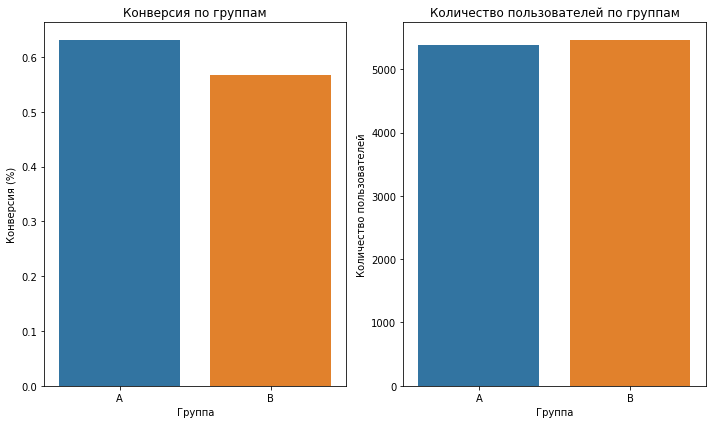

In [27]:
plt.figure(figsize=(10, 6))

# График конверсии
plt.subplot(1, 2, 1)
sns.barplot(data=summary_data, x='group', y='conversion_rate')
plt.title('Конверсия по группам')
plt.ylabel('Конверсия (%)')
plt.xlabel('Группа')

# График количества пользователей
plt.subplot(1, 2, 2)
sns.barplot(data=summary_data, x='group', y='total_visitors')
plt.title('Количество пользователей по группам')
plt.ylabel('Количество пользователей')
plt.xlabel('Группа')

plt.tight_layout()
plt.show()


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Размер групп:  Группы A (контрольная) и B (тестовая) имеют сопоставимые размеры: 5383 и 5467 посетителей соответственно. Это говорит о том, что разделение пользователей на группы было достаточно равномерным.

Конверсия в покупку:


В контрольной группе (A) из 5383 посетителей 34 совершили покупку.
В тестовой группе (B) из 5467 посетителей 31 совершили покупку.
Предварительный вывод об изменении:  Количество покупателей в тестовой группе (B) немного меньше, чем в контрольной группе (A).  Однако, чтобы сделать значимый вывод, нужно рассчитать коэффициенты конверсии и провести статистический анализ (например, z-тест или хи-квадрат), чтобы определить, является ли это различие статистически значимым или случайным.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

In [28]:
# Данные A/B-теста
n1 = 5383  # Общее количество посетителей в группе A
x1 = 34    # Количество покупателей в группе A
n2 = 5467  # Общее количество посетителей в группе B
x2 = 31    # Количество покупателей в группе B

# 1. Рассчитываем коэффициенты конверсии
p1 = x1 / n1
p2 = x2 / n2

# 2. Рассчитываем объединенную оценку пропорции
p = (x1 + x2) / (n1 + n2)

# 3. Рассчитываем Z-статистику
z = (p1 - p2) / math.sqrt(p * (1 - p) * (1/n1 + 1/n2))

# 4. Рассчитываем p-значение (двусторонний тест)
p_value = 2 * (1 - st.norm.cdf(abs(z)))

# Выводим результаты
print(f"Коэффициент конверсии в группе A: {p1:.5f}")
print(f"Коэффициент конверсии в группе B: {p2:.5f}")
print(f"Объединенная оценка пропорции: {p:.5f}")
print(f"Z-статистика: {z:.3f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результатов (сравнение с уровнем значимости alpha)
alpha = 0.05
if p_value < alpha:
    print(f"P-значение ({p_value:.4f}) < уровень значимости ({alpha}). Отвергаем нулевую гипотезу.")
else:
    print(f"P-значение ({p_value:.4f}) >= уровень значимости ({alpha}). Не отвергаем нулевую гипотезу.")

Коэффициент конверсии в группе A: 0.00632
,Коэффициент конверсии в группе B: 0.00567
,Объединенная оценка пропорции: 0.00599
,Z-статистика: 0.436
,P-значение: 0.6630
,P-значение (0.6630) >= уровень значимости (0.05). Не отвергаем нулевую гипотезу.


Мы выбираем уровень значимости alpha = 0.05 .  Если p-значение меньше alpha, мы отвергаем нулевую гипотезу.  В противном случае мы не отвергаем нулевую гипотезу.


В нашем случае, p-значение (0.6630) > alpha (0.05).  Следовательно, мы не отвергаем нулевую гипотезу.

- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

Выводы по результатам проведенной оценки A/B-тестирования:


На основании проведенного A/B-тестирования и статистического анализа с использованием Z-теста для сравнения двух пропорций, мы не обнаружили статистически значимого различия в коэффициентах конверсии между контрольной группой (A) и тестовой группой (B).


P-значение (0.6630) значительно превышает выбранный уровень значимости (alpha = 0.05). Это означает, что вероятность получить наблюдаемую разницу в коэффициентах конверсии (или более экстремальную) при условии, что нулевая гипотеза верна, довольно высока.  Иными словами, наблюдаемая разница может быть результатом случайных колебаний, а не реального эффекта от изменения в тестовой группе.

Мы не можем отвергнуть нулевую гипотезу, которая утверждает, что изменение в тестовой группе (B) не оказывает влияния на конверсию по сравнению с контрольной группой (A).


Что можно сказать про результаты A/B-тестирования:


Результаты A/B-тестирования не подтверждают, что изменение, внесенное в тестовой группе (B), положительно или отрицательно повлияло на конверсию.  Новый вариант (B) показал немного более низкий коэффициент конверсии, чем старый (A), но эта разница не является статистически значимой.


Был ли достигнут ожидаемый эффект в изменении конверсии?


Нет, ожидаемый эффект в изменении конверсии не был достигнут. Мы не можем утверждать, что изменение, внесенное в тестовой группе, привело к какому-либо существенному изменению (увеличению или уменьшению) конверсии.

